In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1o2_hzOA0Ix4lVJGUpm8WQU_f-Bg9e2qi'})
download.GetContentFile('train.csv')

download = drive.CreateFile({'id': '1h_h6bFrQGgmaFPFATepZPOENO3qB7cEd'})
download.GetContentFile('test.csv')

In [0]:
import pandas as pd
train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## 80/20 train/val

In [0]:
x_trainval = train.drop('Label', axis=1).drop('Id', axis=1).values.reshape(len(train),28,28,1).astype('float32')
xn_trainval = x_trainval.astype('float32') #/ 255
y_trainval = train['Label'].values

In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

xn_train, xn_val, y_train, y_val = train_test_split(xn_trainval, y_trainval, test_size=0.2, random_state=42)
print("Train:", xn_train.shape, y_train.shape, "\nValidate: ", xn_val.shape, y_val.shape)

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print("Train:", xn_train.shape, y_train.shape, "\nValidate: ", xn_val.shape, y_val.shape)

Train: (48000, 28, 28, 1) (48000,) 
Validate:  (12000, 28, 28, 1) (12000,)
Train: (48000, 28, 28, 1) (48000, 5) 
Validate:  (12000, 28, 28, 1) (12000, 5)


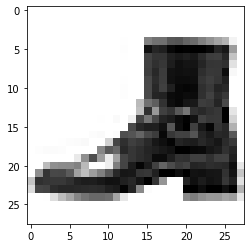

In [0]:
plt.imshow(xn_train[4,:,:,0], cmap='gray_r');

## 60/20/20 train/val/test

In [0]:
x_trainvaltest = train.drop('Label', axis=1).drop('Id', axis=1).values.reshape(len(train),28,28,1).astype('float32')
xn_trainvaltest = x_trainvaltest.astype('float32') #/ 255
y_trainvaltest = train['Label'].values

In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

xn_trainval, xn_test, y_trainval, y_test = train_test_split(xn_trainvaltest, y_trainvaltest, test_size=0.2, random_state=42)
xn_train, xn_val, y_train, y_val = train_test_split(xn_trainval, y_trainval, test_size=0.2, random_state=42)

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print("Train:", xn_train.shape, y_train.shape, "\nValidate: ", xn_val.shape, y_val.shape, "\nTest: ", xn_test.shape, y_test.shape)

Using TensorFlow backend.


Train: (38400, 28, 28, 1) (38400, 5) 
Validate:  (9600, 28, 28, 1) (9600, 5) 
Test:  (12000, 28, 28, 1) (12000, 5)


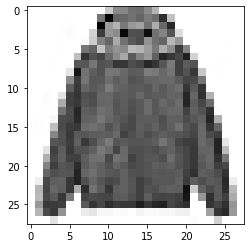

In [0]:
plt.imshow(xn_train[4,:,:,0], cmap='gray_r');

## CNN

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

cdrop = 0.4

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=512, activation='relu'))

model.add(layers.Dense(units=5, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch == 10 or epoch == 15 or epoch == 20 or epoch == 25) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
history = model.fit(xn_train, y_train, validation_data=(xn_val, y_val), epochs=30,
                    batch_size=128, callbacks=[lr_scheduler], verbose=1)

Epoch 1/30
375/375 [==============================] - 2s 5ms/step - loss: 0.6143 - accuracy: 0.7396 - val_loss: 0.4252 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 2s 5ms/step - loss: 0.4176 - accuracy: 0.8286 - val_loss: 0.3577 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 2s 5ms/step - loss: 0.3633 - accuracy: 0.8514 - val_loss: 0.3320 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 2s 5ms/step - loss: 0.3220 - accuracy: 0.8684 - val_loss: 0.2930 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 2s 5ms/step - loss: 0.3000 - accuracy: 0.8764 - val_loss: 0.2734 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 2s 5ms/step - loss: 0.2787 - accuracy: 0.8867 - val_loss: 0.2899 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 7/30
375/375 [==============================] - 2s 5ms/step - lo

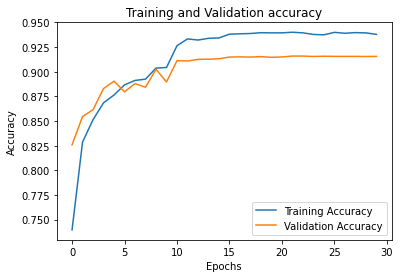

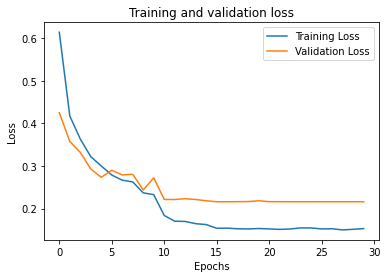

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.figure();
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

In [0]:
# For testing 60/20/20 split
model.evaluate(xn_test, y_test)

375/375 [==============================] - 1s 2ms/step - loss: 0.2360 - accuracy: 0.9137


[0.2360100895166397, 0.9137499928474426]

In [0]:
model.save('Best_model2.h5')

In [0]:
x_test = df_test.drop('Id', axis=1).values.reshape(len(df_test),28,28,1)
x_test = x_test.astype('float32') / 255

In [0]:
import time
st = time.time()
catpred = model.predict(x_test_resnet)
print('Time:', time.time() - st)

In [0]:
preds = []
for i in catpred:
    pred = np.argmax(i)
    preds.append(pred)
preds =np.array(preds)
preds

array([4, 4, 0, ..., 3, 2, 2])

In [0]:
df_test['Id'].values.shape

(10000,)

In [0]:
df_sub = pd.DataFrame(df_test['Id'])
df_sub['Label'] = preds
df_sub.to_csv('submission2.csv', index=False)

In [0]:
from google.colab import files
files.download("submission2.csv")

In [0]:
from google.colab import files
files.download("Best_model2.h5")

## ResNet

In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

xn_train, xn_val, y_train, y_val = train_test_split(xn_trainval, y_trainval, test_size=0.2, random_state=42)
print("Train:", xn_train.shape, y_train.shape, "\nValidate: ", xn_val.shape, y_val.shape)

#xn_trainval, xn_test, y_trainval, y_test = train_test_split(xn_trainvaltest, y_trainvaltest, test_size=0.2, random_state=42)
#xn_train, xn_val, y_train, y_val = train_test_split(xn_trainval, y_trainval, test_size=0.2, random_state=42)

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#y_test = to_categorical(y_test)
#print("Train:", xn_train.shape, y_train.shape, "\nValidate: ", xn_val.shape, y_val.shape, "\nTest: ", xn_test.shape, y_test.shape)

Train: (48000, 28, 28, 1) (48000,) 
Validate:  (12000, 28, 28, 1) (12000,)


Using TensorFlow backend.


In [0]:
import PIL

x_train_r = np.pad(xn_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_train_resnet = np.empty((len(x_train_r), 32, 32, 3))
for i in range(len(x_train_resnet)):
    x_train_resnet[i, :, :] = np.asarray(PIL.Image.fromarray(x_train_r[i,:,:,0]).convert('RGB'))
print('Training set:', x_train_resnet.shape)

x_val_r = np.pad(xn_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_val_resnet = np.empty((len(x_val_r), 32, 32, 3))
for i in range(len(x_val_resnet)):
    x_val_resnet[i, :, :] = np.asarray(PIL.Image.fromarray(x_val_r[i,:,:,0]).convert('RGB'))
print('Validation set:', x_val_resnet.shape)

Training set: (48000, 32, 32, 3)
Validation set: (12000, 32, 32, 3)


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

input_shape = (32,32,3)
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
output = keras.layers.Flatten()(restnet.layers[-1].output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = True
#restnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


"\nrestnet.trainable = True\nset_trainable = False\nfor layer in restnet.layers:\n    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:\n        set_trainable = True\n    if set_trainable:\n        layer.trainable = True\n    else:\n        layer.trainable = False\n"

In [0]:
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
import tensorflow as tf
tf.keras.backend.clear_session()

model = Sequential()
model.add(restnet)
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 24,647,557
Trainable params: 24,590,341
Non-trainable params: 57,216
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
history = model.fit(x_train_resnet, y_train, validation_data=(x_val_resnet, y_val),
                    epochs=10, batch_size=128, callbacks=[lr_scheduler], verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 61s 1ms/step - loss: 0.4809 - accuracy: 0.7660 - val_loss: 0.3151 - val_accuracy: 0.8654
Epoch 2/10
48000/48000 [==============================] - 47s 987us/step - loss: 0.2571 - accuracy: 0.8875 - val_loss: 0.2200 - val_accuracy: 0.9040
Epoch 3/10
48000/48000 [==============================] - 47s 988us/step - loss: 0.1975 - accuracy: 0.9139 - val_loss: 0.1831 - val_accuracy: 0.9204
Epoch 4/10
48000/48000 [==============================] - 47s 982us/step - loss: 0.1642 - accuracy: 0.9296 - val_loss: 0.1616 - val_accuracy: 0.9291
Epoch 5/10
48000/48000 [==============================] - 48s 995us/step - loss: 0.1412 - accuracy: 0.9403 - val_loss: 0.1498 - val_accuracy: 0.9355
Epoch 6/10
48000/48000 [==============================] - 47s 973us/step - loss: 0.1233 - accuracy: 0.9497 - val_loss: 0.1469 - val_accuracy: 0.9361
Epoch 7/10
48000/48000 [==============================] - 

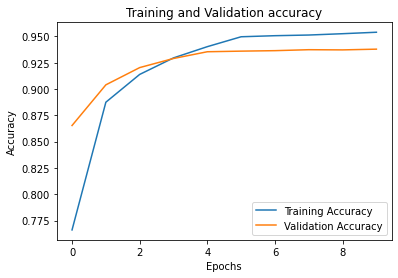

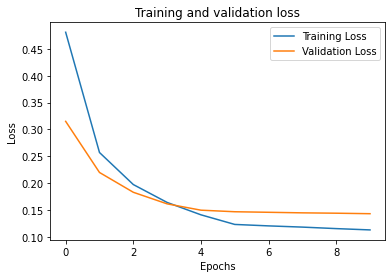

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.figure();
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

In [0]:
# For testing 60/20/20 split
model.evaluate(x_test_resnet, y_test)

12000/12000 [==============================] - 6s 531us/step


[0.2469706539089481, 0.954633355140686]

In [0]:
model.save('Best_resnet_model.h5')

In [0]:
x_test = df_test.drop('Id', axis=1).values.reshape(len(df_test),28,28,1)
x_test_r = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test_r = x_test_r.astype('float32')
x_test_resnet = np.empty((len(x_test_r), 32, 32, 3))
for i in range(len(x_test_resnet)):
    x_test_resnet[i, :, :] = np.asarray(PIL.Image.fromarray(x_test_r[i,:,:,0]).convert('RGB'))
print(x_test_resnet.shape)

(10000, 32, 32, 3)


In [0]:
import time
st = time.time()
catpred = model.predict(x_test_resnet)
print('Time:', time.time() - st)

In [0]:
preds = []
for i in catpred:
    pred = np.argmax(i)
    preds.append(pred)
preds =np.array(preds)
preds

array([3, 4, 0, ..., 4, 2, 2])

In [0]:
df_test['Id'].values.shape

(10000,)

In [0]:
df_sub = pd.DataFrame(df_test['Id'])
df_sub['Label'] = preds
df_sub.to_csv('resnet_submission.csv', index=False)

In [0]:
from google.colab import files
files.download("resnet_submission.csv")

In [0]:
from google.colab import files
files.download("Best_resnet_model.h5")